# Data representation with MPPData
MPPData is the main data representation for the data used in this project.
It is represented on disk by a folder containing npy and csv files. Assuming N observations/pixels and C protein channels, the data is saved in:
- mpp.npy: NxC, per-pixel values
- x.npy, y.npy: Nx1, spatial coordinates of each pixel
- obj_ids.npy: Nx1, object id (cell) that each pixel belongs to
- channels.csv: C, protein channel names
- metadata.csv: #objects, metadata information (perturbation, cell cycle, etc) for each object (cell)

During processing of the data, additional npy files might be created. For example, after training a cVAE and clustering its latent space into ICLs, the results directory will also contain:
- conditions.npy: Nx#conditions, conditions used to train the cVAE
- latent.npy: Nx#latent, latent space of the cVAE used for clustering of ICLs
- clustering.npy: Nx#clusters, clustering of latent.npy
- cluster_annotation.csv: #clusters, mapping of clusters to cluster names

TODO add comments and a bit more info in the following

In [1]:
import importlib
import sys
sys.path.append('..')

import campa.data._data
from campa.data._data import MPPData
importlib.reload(campa.data._data)

from campa.utils import init_logging
import os
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
#init_logging()

### Load data into MPPData class

First, set up the config.ini file in the main directory:

1. Field [DEFAULT]

**experiment_dir** is the path to the directory where experiment results
were stored

**data_dir** is the path to directory were all data is stored.
This folder could contain separate folders for different perturbations,
 within which folders corresponding to the separate wells are stored.

2. Field [data]

Each constant there contains a path to a python file, where parameters that are specific to the required data load are stored. Please refer to e.g. "notebooks/params/NascentRNA_constants_1" to see an example.
___

To construct the MPPData entity, the following params are then provided:

1. **data_dir**: Path to the specific directory containing one set of npy
and csv files as described above. Note that this path should be
relative to the 'base_dir',which is either provided implicitly in the function or set to **data_dir** path specified in config.ini
otherwise.
2. **data_config**: Name of the constant in the [data] field of
config.ini file, which contains path to the python file with configuration
parameters for loading the data.



In [2]:
mpp_data = campa.data._data.MPPData.from_data_dir('184A1_unperturbed/I09', data_config='NascentRNA')
print(mpp_data)

INFO:MPPData:Created new: MPPData for NascentRNA_test (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.


MPPData for NascentRNA_test (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


### Subset data

There, several options for subsetting the data exist.

#### 1. Subset by channel names:

For that, one needs to provide a list of channels (represented as string values).
MPP object will then be restricted by the channels that are present  both in the provided list and the *mpp_data.channels*.
Note that this operation is performed inpl|ce and will update fields ***mpp_data.mpp*** and ***mpp_data.channels***.

In [3]:
#subset channels
channels = [
        '01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6', '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A',
        '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811',
        '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2',
        '18_NONO', '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI', '07_H2B'
        ]

mpp_data.subset_channels(channels)

INFO:MPPData:Subsetting from 35 channels
INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:The following channels were excluded ['00_EU']


#### 2. Objects-level subsetting:

A method 'subset' allows one to subset ***objects (cells)*** of mpp data in multiple ways: by random fraction
or random number of ***objects***, by object ids, or be specified values in the metadata table. Note that several conditions for subsetting can be provided, and the resulting MPP object will be a computed as combination of all the provided conditions.
Below are several examples of how this function can be utilized:

    2.1. Subset by the values in the metadata table:

For that, one needs to specify a name of the column in the metadata table and
 a set of allowed entries for that column.
A special entry "NO_NAN" is a special token selecting all values except nan.
Here one could also provide several columns together with their entries,
separated by a comma, and the resulting MPP object will be computed as a combination of all provided conditions.

In [4]:
# filter by NO_NAN cellcycle stage
# perform operation inplace
print("Cell cycle entries before subsetting by NO_NAN values:", (mpp_data.metadata.cell_cycle).unique())
mpp_data.subset(cell_cycle='NO_NAN')
print("Cell cycle entries after subsetting to NO_NAN values:", np.unique(mpp_data.metadata.cell_cycle))

INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 557 objects


Cell cycle entries before subsetting by NO_NAN values: [nan 'S' 'G1' 'G2']
Cell cycle entries after subsetting to NO_NAN values: ['G1' 'G2' 'S']


In [5]:
# filter by specified cellcycle entries
# here, a new object is created, leaving an mpp_data object untouched
values=['G1', 'G2']
print(f"Cell cycle entries before subsetting by {values} values: {(mpp_data.metadata.cell_cycle).unique()}")
mpp_data_subset=mpp_data.subset(cell_cycle=['G1', 'G2'], copy=True)
print(f"Cell cycle entries after subsetting to {values} values: {np.unique(mpp_data_subset.metadata.cell_cycle)}")

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to cell_cycle=['G1', 'G2']: 384 objects


Cell cycle entries before subsetting by ['G1', 'G2'] values: ['S' 'G1' 'G2']


INFO:MPPData:Created new: MPPData for NascentRNA_test (4847587 mpps with shape (1, 1, 34) from 384 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


Cell cycle entries after subsetting to ['G1', 'G2'] values: ['G1' 'G2']


    2.2. Subset a random fraction of objects.

Another option is to subsample a random number of objects (cell).
This could either be done by specifying a fraction of objects or a number of objects:

In [6]:
# Subset fraction of objects:
mpp_data_sub = mpp_data.subset(frac=0.05, copy=True)
print(f"Subset fraction: {mpp_data_sub.mpp.shape[0]/mpp_data.mpp.shape[0]}")

# Subset specific number of objects:
mpp_data_sub = mpp_data.subset(num=27, copy=True)
print(f"Subset fraction: {mpp_data_sub.mpp.shape[0]/mpp_data.mpp.shape[0]}")


INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 27 random objects
INFO:MPPData:Created new: MPPData for NascentRNA_test (357079 mpps with shape (1, 1, 34) from 27 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 27 random objects


Subset fraction: 0.049469230850222576


INFO:MPPData:Created new: MPPData for NascentRNA_test (357079 mpps with shape (1, 1, 34) from 27 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


Subset fraction: 0.049469230850222576


2.3. Subset by object ids

In [7]:
# subset to one cell
mpp_data_sub = mpp_data.subset(obj_ids=mpp_data.unique_obj_ids[:1], copy=True)

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA_test (17008 mpps with shape (1, 1, 34) from 1 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


## Data conditions

### 1. Creating conditions

Withing a framework of conditional VAE training, a conditional vector is passed alongside the input vector.
This vector could represent e.g. perturbation or a cell cycle.
The vector is constructed for each input sample (here, we refer to an input sample is a pixel or a pixel's neighbourhood)
from a metadata table as a concatenation of vectors each representing separate condition.

In order to create a conditions table, method add_conditions(), which takes the following parameters:

   1. cond_desc: a list of conditions descriptions, represented as string values. Conditions can be represented in one of the following formats:
    - columnName - if this column is specified in data_config.CONDITIONS, then a value in that column gets numerically encoded into a class value (1, 2, ...).
   Note that the class is assigned to the value only if the values is contained in range of values that column could take (as specified in data_config.CONDITIONS[columnName]). Note that one can also provide a special entrie "UNKNOWN" there. In that case, all values with conditions that are not listed are mapped to the additional last class.
If the column name is not provided in the data_config.CONDITIONS, values are assumed to be continious and stored as they are in the conditions table.
    - columnName_postrpocess, where postprocess can be set to one of the following values:
        - lowhigh_bin_2: bins all values in the specified column in 4 quantiles, encodes values in the
   lowest quantile as one class and values in the high quantile as teh second class (one-hot encoded), and all values in-between sets to None
        - bin_3: bin values in .33 and .66 quantiles and one-hot encodes each of them into 3 classes according to quantile where the value belongs to
        - zscore: normalizes a continuous set of values by mean and std of train subset, supposed to be used only after a train-test split up
        - one_hot: same as when only ***columnName*** is provided as a condition description, but additionally one-hot encodes the class values.

2. cond_params: Parameters used for e.g. classyfying values into bins could optionally be stored into a dictionary (where appropriate). A dictionary for storing this values then needs to be provided.

NOTE: Operation is performed **inplace**.

In [8]:
# add conditions
cond_params = {}
mpp_data.add_conditions(['TR_norm_lowhigh_bin_2', 'TR_bin_3', 'cell_cycle'], cond_params=cond_params)

print(mpp_data.conditions)
print(cond_params)

INFO:MPPData:Adding conditions: ['TR_norm_lowhigh_bin_2', 'TR_bin_3', 'cell_cycle']
INFO:MPPData:Looking up condition TR_norm, with postprocess lowhigh_bin_2
INFO:MPPData:Looking up condition TR, with postprocess bin_3
INFO:MPPData:Looking up condition cell_cycle, with postprocess None
INFO:convert_condition:Converting condition cell_cycle to numbers


[[ 0.  1.  0.  0.  1.  2.]
 [ 0.  1.  0.  0.  1.  2.]
 [ 0.  1.  0.  0.  1.  2.]
 ...
 [nan nan  0.  1.  0.  1.]
 [nan nan  0.  1.  0.  1.]
 [nan nan  0.  1.  0.  1.]]
{'TR_norm_lowhigh_bin_2_quantile': [338.1978527745389, 418.8766845744007], 'TR_bin_3_quantile': [362.1374296178866, 411.146330758427]}


### 2. Condition-based filtering

Additionally, values could be filtered based on a created conditions: all values having
nan conditions will be filtered out.

The way condition's creation is implemented allows one to e.g. leave only entries
 which values in the specified column were
in the low and high quantilies, and filtering out everything else. For that, "columnName_TR_norm_lowhigh_bin_2" condition needs to be created beforehand (see description above).


In [9]:
# filter objects with nan conditions
mpp_data.subset(nona_condition=True)

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 283


## Data preparation

To prepare the data, pixel values can be normalized. For that, pixel values can be e.g. shifted and rescaled so that they end up ranging between 0 and 1:
To perform a normalization, **normalze()** is used, which can take the following parameters:
1. (optional) background_value: shifts all values (contained in .data field) by that value. Note that all resulting
negative values are cut off to zero. Several shift options are possible, depending on a background_value, which could be in one of the following formats:
   - single value (float): then data is shifted by this number in every channels
   - list of predifined values (floats): data in each channel is shifted separately by a corresponding value in that list. Note: in that case, number of shifted
values should be the same as number of channels.
   - string: list of values for shifting are loaded from the channels_metadata table (should be located in the folder data_config.DATA_DIR
in a file self.data_config.CHANNELS_METADATA). The values are then loaded from the column corresponding to a provided string value.

2. (optional) percentile: after (optional) shifting data can be rescaled by a specified value separately for each channel.
The value could be in one of the following formats:
    - float: value from 0 to 100, which represents a quantile by which data should be rescaled.
   Quantiles are then calculated for each channel separately, and data is rescaled independently in each channel
by the calculated respective quantile value.
    - list of predifined values (floats): data in each channel is rescaled separately for each channel by a corresponding value in that list.

3. (optional) rescale_values: Parameters calculated for rescaling could optionally be stored into a list, which needs to be provided to the function.

NOTE: this operation is performed **inplace**.

In [10]:
# normalise data: shift it by mean_background values(provided in channels_metadata) and then rescale each channel separately by dividing values by the corresponding 98.0 percentile.
rescale_values = []
mpp_data.normalise(background_value='mean_background', percentile= 98.0, rescale_values=rescale_values)
print(rescale_values)

INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channel with 98.0 percentile


[53.889077674895006, 61.29248486934, 288.580564999614, 94.797795010537, 46.969012700825004, 196.166104554605, 102.192703487811, 334.88636174276803, 95.989850032596, 111.921074631886, 216.454320872445, 276.374678140131, 198.10488029550498, 569.873113168236, 124.093431062583, 76.143769097638, 194.20852422806, 211.926705230017, 420.026212072665, 479.722105769381, 156.451838886362, 227.390029544676, 84.901763855899, 458.498049074523, 150.04311273660198, 175.21535973943702, 629.34514056733, 139.20844135918, 709.734122587939, 229.365936479147, 26.306330100778, 199.97347517141299, 70.3, 322.3]


## MPP representation

One could extends mpp representation with a square neighbourhood around it. For that, method ***add_neighborhood()*** is used, which takes the following parameter:
   - ***neighborhood_size***: size ***n*** of the neighborhood.

The resulting mpp representation will then be set to a ***nXn*** square around each pixel.


In [11]:
# add neighbors

#first, lets subsample the data to reduce computational burden
mpp_data_sub = mpp_data.subset(frac=0.05, copy=True)
mpp_data_neighb=mpp_data_sub.add_neighborhood(size=3, copy=True)

print(f"MPP dataset before adding the neighbourhood, has neighbor data: {mpp_data_sub.has_neighbor_data}")
print(f"Representation of one MPP before adding the neighbourhood (first channel)\n: {mpp_data_sub.mpp[0,:, :, 0]}")

print(f"MPP dataset after adding the neighbourhood, has neighbor data: {mpp_data_neighb.has_neighbor_data}")
print(f"Representation of one mpp after adding the neighbourhood (first channel)\n: {mpp_data_neighb.mpp[0, :, :, 0]}")


INFO:MPPData:Before subsetting: 283 objects
INFO:MPPData:Subsetting to 14 random objects
INFO:MPPData:Created new: MPPData for NascentRNA_test (161569 mpps with shape (1, 1, 34) from 14 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Adding neighborhood of size 3
INFO:MPPData:Created new: MPPData for NascentRNA_test (161569 mpps with shape (3, 3, 34) from 14 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].


MPP dataset before adding the neighbourhood, has neighbor data: False
Representation of one MPP before adding the neighbourhood (first channel)
: [[0.03505493]]
MPP dataset after adding the neighbourhood, has neighbor data: True
Representation of one mpp after adding the neighbourhood (first channel)
: [[0.03505493 0.03505493 0.03505493]
 [0.03505493 0.03505493 0.03505493]
 [0.03505493 0.18350801 0.        ]]


### MPP-level subsampling

A method ***subsample()*** allows one to subsample ***mpps*** (could be thought of as pixels) in multiple ways (by a random fraction
or random number of ***pixels*** either from all dataset or from each object independently). Additionally, can extend mpps' representations by their neighbourhoods. Note that several conditions for subsampling can be provided,
 and the resulting MPP Dataset will be computed as combination of all the provided conditions.
The method can take the following parameters:
   - ***frac***: subsample a random number of mpps (pixels) from the whole dataset by a specified fraction.
Should be provided in range [0, 1].
   - ***num***: subsample a random number of mpps (pixels) from the whole dataset by a specified number of mpps to be chosen.
   - ***frac_per_obj***: allows to subsample a fraction of mpps on the object level - that is, for each object (cell) to subsample the same fraction
of mpps independently.
   - ***num_per_obj***: same as frac_per_obj, but a number of mpps to be left instead of fraction is provided
   - ***add_neighborhood***: if set to True, extends mpp representation with a square neighbourhood around it
   - ***neighborhood_size***: size of the neighborhood

Note that at least one of four parameters that indicate subsampling (frac, num, frac_per_obj, num_per_obj) size should be provided

In [12]:
# subsample and add neighbourhood

mpp_data_sub = mpp_data.subsample(frac_per_obj=0.05,
add_neighborhood=True, neighborhood_size=3)

print(f"Subset fraction: {mpp_data_sub.mpp.shape[0]/mpp_data.mpp.shape[0]}")

print(f"MPP representation before adding the neighbourhood (first channel)\n: {mpp_data.mpp[0,:, :, 0]}")
print(f"MPP representation after adding the neighbourhood (first channel)\n: {mpp_data_sub.mpp[0, :, :, 0]}")

# Note that since a random subsampling was performed, first value in the mpp_data does not necessarily
# correspond to the first element in mpp_data_sub

INFO:MPPData:Subsampling each object to 5.0%
INFO:MPPData:Created new: MPPData for NascentRNA_test (181018 mpps with shape (1, 1, 34) from 283 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
INFO:MPPData:Adding neighborhood of size 3


Subset fraction: 0.049962931743069226
MPP representation before adding the neighbourhood (first channel)
: [[0.05361156]]
MPP representation after adding the neighbourhood (first channel)
: [[0.14639474 0.0721682  0.1278381 ]
 [0.         0.         0.23917793]
 [0.25773457 0.14639474 0.0721682 ]]


## Data visualization

One can visualize several channels of the data of either part of the data or a separate object (cell)
NOTE: one can plot either one or three different channels at a time.
First, lets plot a part of all mpp objects withing a certain size via ***get_img()*** method, which take the following params:
- ***data***: key in self._data that should be plotted on the image
- ***channel_ids***: Channels that the image should have, only relevant if key == 'mpp'. NOTE: if one uses plt.imshow() fro visualization afterwards, you can plot either one or three different channels at a time.
- ***img_size*** (optional): size of returned image. If provided, image is padded or cropped to the desired size,
and returns resulting image. If not provided, returns image and pad parameters from padding (pad set to 0 by default)
- ***pad***(optional): amount of padding added to returned image (only used when img_size is None). If  provided,
returns image and a list of padding parameters used for image padding.

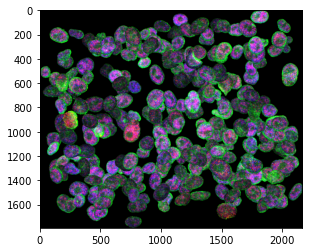

In [13]:
import matplotlib.pyplot as plt

img, _ = mpp_data.get_img(channel_ids=[0,1,10],)
plt.imshow(img)

Now let's plot a separate object (cell). For that, a method ***get_object_img()*** is used, which can take the following parameters:
- ***obj_id***: an ID of the object (cell)
- ***data***: key in self._data that should be plotted on the image
- ***channel_ids***: Channels that the image should have, only relevant if key == 'mpp'. NOTE: if one uses plt.imshow() fro visualization afterwards, you can plot either one or three different channels at a time.
- ***img_size*** (optional): size of returned image. If provided, image is padded or cropped to the desired size,
and returns resulting image. If not provided, returns image and pad parameters from padding (pad set to 0 by default)
- ***pad***(optional): amount of padding added to returned image (only used when img_size is None). If  provided,
returns image and a list of padding parameters used for image padding.

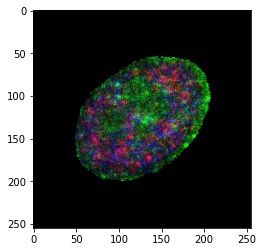

In [14]:
# get and plot image of
import matplotlib.pyplot as plt

img = mpp_data.get_object_img(mpp_data.unique_obj_ids[0],
channel_ids=[0,1,10], img_size=255)
plt.imshow(img)


(255, 255, 34)


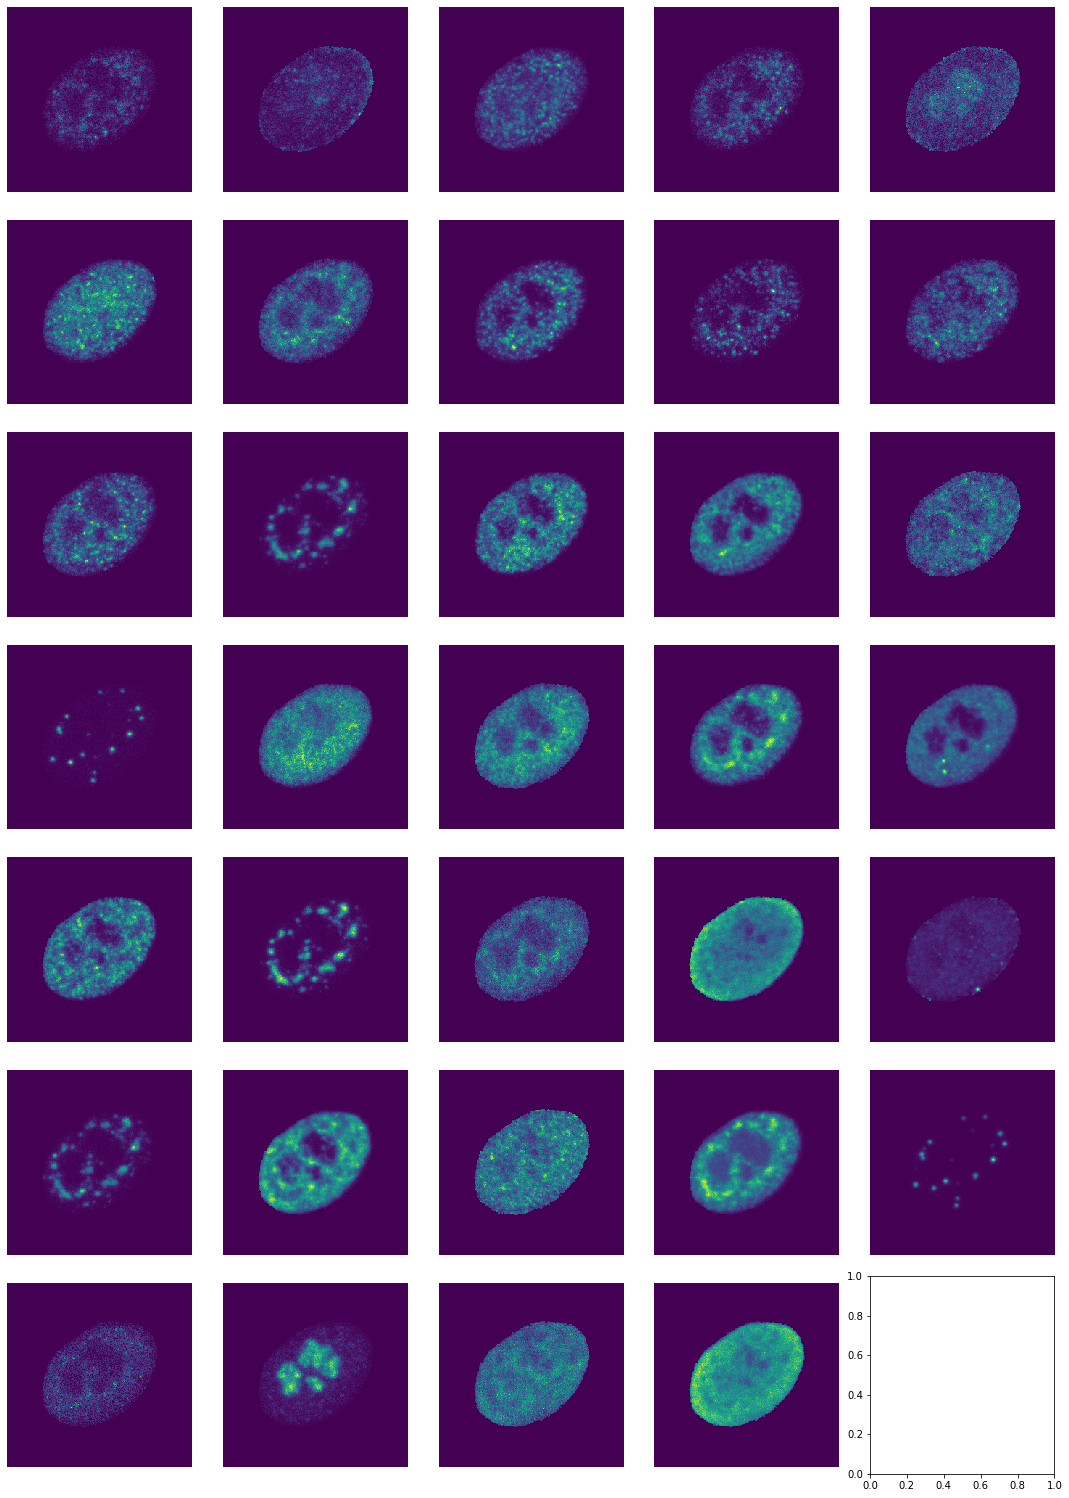

In [15]:
# get and plot all channels available for one subject

import matplotlib.pyplot as plt

img = mpp_data.get_object_img(mpp_data.unique_obj_ids[0], img_size=255)
print(img.shape)
num_cols=5
num_channels=mpp_data.channels.nunique()[0]
num_rows=num_channels//num_cols+1

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(int(3*num_cols), int(3*num_rows)))
i=0
for row in range(num_rows):
    for col in range(num_cols):
        if i>=num_channels:
            break
        axes[row][col].imshow(img[:, :, i],interpolation='none')
        axes[row][col].axis('off')
        i+=1
plt.tight_layout()
plt.show()

One can also get a list of images for the list of provided objects. For that, a method ***get_object_imgs()*** is used, which takes the same params as ***get_object_img()***,
 but returns a list of images instead of one image:

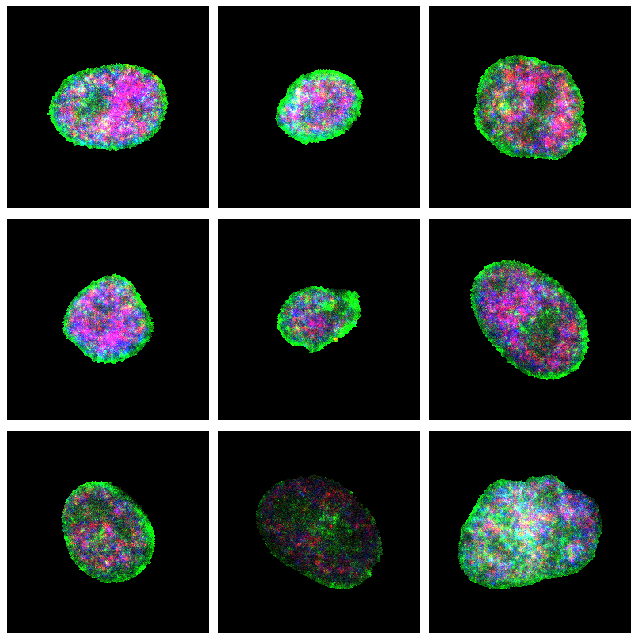

In [16]:
# Let's get imnages for all available cells and plot firt nine:
img = mpp_data.get_object_imgs(channel_ids=[0,1,10], img_size=255)
num_rows, num_cols=3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=((int(3 * num_rows), int(3 * num_cols))))
i=0
for row in range(num_rows):
    for col in range(num_cols):
        axes[row][col].imshow(img[i],interpolation='none')
        axes[row][col].axis('off')
        i+=1
plt.tight_layout()
plt.show()
plt.close()

## Conversion to adata
One can store mpp data as adata object. This can be advantageous, as one can on utilize e.g. scanpy package for further analysis.

In [17]:
# Let's create an adata object for a separate cell. For that, we first need to subset it to one cell,
# and then call a get_adata() method

# subset to one cell
mpp_data_sub = mpp_data.subset(obj_ids=mpp_data.unique_obj_ids[:1], copy=True)

# get adata object from information in MPPData
adata = mpp_data_sub.get_adata()
adata

INFO:MPPData:Before subsetting: 283 objects
INFO:MPPData:Subsetting to 1 objects
INFO:MPPData:Created new: MPPData for NascentRNA_test (17008 mpps with shape (1, 1, 34) from 1 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels', 'conditions'].
/Users/nastassya.horlava/opt/anaconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 17008 × 34
    obs: 'mapobject_id', 'plate_name', 'well_name', 'well_pos_y', 'well_pos_x', 'tpoint', 'zplane', 'label', 'is_border', 'mapobject_id_cell', 'plate_name_cell', 'well_name_cell', 'well_pos_y_cell', 'well_pos_x_cell', 'tpoint_cell', 'zplane_cell', 'label_cell', 'is_border_cell', 'is_mitotic', 'is_mitotic_labels', 'is_polynuclei_HeLa', 'is_polynuclei_HeLa_labels', 'is_polynuclei_184A1', 'is_polynuclei_184A1_labels', 'is_SBF2_Sphase_labels', 'is_SBF2_Sphase', 'Heatmap-48', 'cell_cycle', 'description', 'dimensions', 'id', 'cell_type', 'EU', 'duration', 'perturbation', 'secondary_only', 'siRNA', 'perturbation_duration', 'LocalDensity_Nuclei_800', 'TR', 'TR_factor', 'TR_norm', 'MERGE_KEY'
    var: 'name'
    obsm: 'spatial'

/Users/nastassya.horlava/opt/anaconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate_name' as categorical
/Users/nastassya.horlava/opt/anaconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'well_name' as categorical
/Users/nastassya.horlava/opt/anaconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pan

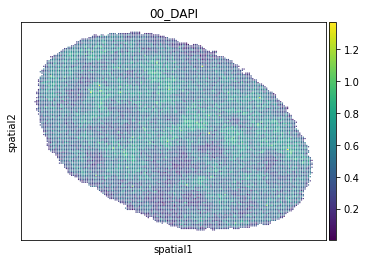

In [18]:
# with adata, can use all scanpy functions, e.g. spatial plotting
import scanpy as sc
sc.pl.embedding(adata, basis='spatial', color=['00_DAPI'])